In [1]:
import numpy as np 

import pandas as pd 

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt  

import statsmodels.tsa 
from statsmodels.tsa.api import acf , pacf_ols ,adfuller 

from statsmodels.tsa.holtwinters import ExponentialSmoothing 


In [2]:
import  statsmodels.tsa.api as smt 
import statsmodels.api as sm


## from  stldecompose import decompose                        
## Showing error that is why decompose method is not used for model building. 

In [4]:
data = pd.read_csv(r"C:\Users\ACER\Downloads\ML assingment\13. Capstone Case Study - Demand Estimation\Electricity Consumption.csv")

In [5]:
## Changing the name for easy access:

data.rename({"DATE":"date", "Electricty_Consumption_in_TW":"electricty_consumption_in_tw" }, axis=1, inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date                          561 non-null    object 
 1   electricty_consumption_in_tw  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [7]:
data

,date,electricty_consumption_in_tw
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


## PRE-REQUISITE FOR FORCASTING PROBLEM : 

### 1) INDEX BY DATE TIME VARIABLE 

### 2) UNIFORM INTERVAL DATA 

### 3) NO MISSING IN INDEX (DATE TIME VARIABLE)


In [8]:
## 1)  Changing the variable to date-time first : 
data["new_date"] = pd.to_datetime(data.date)

In [9]:
## Removing old date variable as its duplicate : 
data.drop(["date"], axis=1, inplace=True)




In [10]:
## Indexing the new date varialbe (which is in date_time data type): 

data.set_index("new_date", inplace=True)

In [11]:
## Now we can see, that in info the indexing has change : 

data.info()

## Now its a normal Time series data : 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 1973-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   electricty_consumption_in_tw  561 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


In [12]:
## 2) checking for interval of index variable : 
## 3) checkinh for missing in interval :
data["month"] = data.index.month_name()

In [13]:
data.month.value_counts()

August       47
September    47
May          47
July         47
February     47
March        47
April        47
June         47
January      47
November     46
December     46
October      46
Name: month, dtype: int64

### As we can see the data in uniform as monthly basis but its have 3 missing details of latest year for 
### October2019 , Novembar2019 and December 2019.

In [14]:
## Missing Check : 

data.isna().sum()

## No missing 

electricty_consumption_in_tw    0
month                           0
dtype: int64

<AxesSubplot:>

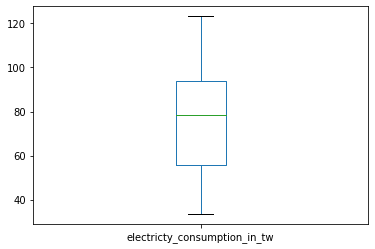

In [15]:
## Check for outliers : 

data.electricty_consumption_in_tw.plot.box()

In [16]:
## Spilt the data into train - test : 
data.drop({"month"},axis=1, inplace=True)

In [17]:
data

,electricty_consumption_in_tw
new_date,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107
...,...
2019-05-01,97.5860
2019-06-01,110.8580
2019-07-01,122.1014


In [18]:
train = data['1973-01-01':'2018-12-01']

test = data['2019-01-01':]


## EDA 

In [19]:
## Trend and Seasonality check : 


In [20]:
decomp = seasonal_decompose(train.electricty_consumption_in_tw,model= "multiplicative")

In [21]:
decomp.seasonal

new_date
1973-01-01    1.054483
1973-02-01    0.997125
1973-03-01    0.946107
1973-04-01    0.890831
1973-05-01    0.918733
                ...   
2018-08-01    1.135873
2018-09-01    1.039143
2018-10-01    0.936749
2018-11-01    0.924450
2018-12-01    1.001367
Name: seasonal, Length: 552, dtype: float64

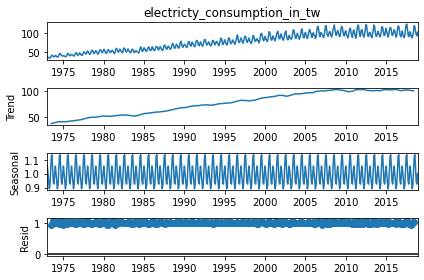

In [22]:
decomp.plot()
plt.rcParams["figure.figsize"] = (15,10)


## As we can see that data have both trend and seaseonality. 

In [23]:
decomp.resid.mean()   ## And we can also sea that the irregular component is near to 1 , means our electricty_consumption_in_tw
## component is haveing a strong infulence of Trend and Seasonality. 

0.9999231901488932

In [24]:
## Check for random walk : (perform ACF)


rand_check = pd.DataFrame(acf(train.electricty_consumption_in_tw,nlags=5)).T

## As there is correlations between lags values so, its not a random walk and we can do the forcasting.  

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [25]:
rand_check.rename({0:"lag0", 1:"lag1",2:"lag2",3:"lag3",4:"lag4",5:"lag5"}, axis=1, inplace=True )

In [26]:
rand_check

## As there is correlations between lags values so, its not a random walk and we can do the forcasting.  

,lag0,lag1,lag2,lag3,lag4,lag5
0,1.0,0.957434,0.882248,0.836281,0.84918,0.894028


In [27]:
## Check for whether data is staionary series data or not : (Adfuller test) 
adfuller(train.electricty_consumption_in_tw)[1]

## We can say that its not an stationary series data. and we need to make it staionary series data. 

0.25666120361577743

## Model building by ETS method : 

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [29]:
from sklearn.metrics import mean_absolute_error

def auto_hwm(timeseries, val_split_date, alpha=[None], beta=[None], gamma=[None], 
              trend=None, seasonal=None, periods=None, verbose=False):

    best_params = []
    actual = timeseries[val_split_date:]

    print('Evaluating Exponential Smoothing model for', len(alpha) * len(beta) * len(gamma), 'fits\n')

    for a in alpha:
        for b in beta:
            for g in gamma:

                    if(verbose == True):
                        print('Checking for', {'alpha': a, 'beta': b, 'gamma': g})

                    model = ExponentialSmoothing(timeseries, trend=trend, seasonal=seasonal, seasonal_periods=periods)
                    model.fit(smoothing_level=a, smoothing_slope=b, smoothing_seasonal=g)
                    f_cast = model.predict(model.params, start=actual.index[0])
                    score = np.where(np.float64(mean_absolute_error(actual, f_cast)/actual).mean()>0,np.float64(mean_absolute_error(actual, f_cast)/actual).mean(),0)

                    best_params.append({'alpha': a, 'beta': b, 'gamma': g, 'mae': score})

    return min(best_params, key=lambda x: x['mae'])

In [30]:
alpha = [0.1,0.2,0.3,0.4,0.5,0.6, .7,.8]
beta = [0.1,0.2,0.3,0.4,0.5,0.6]
gamma =[0.1,0.2,0.3,0.4,0.5,0.6]

In [31]:
ts = train.electricty_consumption_in_tw

## As we are using triple Exponential model as data have both trend and seasonality , so the unknows as alpha , Beta and Gamma.

In [32]:
auto_hwm(ts, val_split_date ='1990-12-01' , alpha=alpha, beta=beta, gamma=gamma, 
              trend='mul', seasonal='mul', periods=12, verbose=True)

Evaluating Exponential Smoothing model for 288 fits

Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.1}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.5}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.1, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.1, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.2}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.5}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.2, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.5}
Checking f

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.2, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.4}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.5}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.3, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.1}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.3, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.5}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.3, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.1, 'gamma': 0.6}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.3}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.3}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.2}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No 

Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.4, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.1}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.4}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.2}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.4}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:743: ConvergenceWarning: Optimization failed to

Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.5, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.1}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.2}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.1}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.2}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.6, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.5}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.6, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.1}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.3}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.3}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.2}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.7, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.1}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.5}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.7, 'beta': 0.6, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.1, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.3}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.2, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.3, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.4}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.4, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.1}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.5, 'gamma': 0.6}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.1}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.2}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.3}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.4}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.5}
Checking for {'alpha': 0.8, 'beta': 0.6, 'gamma': 0.6}


C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information 

{'alpha': 0.7, 'beta': 0.1, 'gamma': 0.2, 'mae': array(0.01909396)}

In [33]:
ets_model = ExponentialSmoothing(ts, trend='mul', seasonal='mul', seasonal_periods=12).fit(smoothing_level=0.7, smoothing_slope=0.1, smoothing_seasonal=0.2)

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [34]:
print(ets_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  552
Model:             ExponentialSmoothing   SSE                           2028.418
Optimized:                         True   AIC                            750.408
Trend:                   Multiplicative   BIC                            819.425
Seasonal:                Multiplicative   AICC                           751.691
Seasonal Periods:                    12   Date:                 Thu, 12 May 2022
Box-Cox:                          False   Time:                         11:16:40
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7000000                alpha                False
smoothing_slope          

In [35]:
ets_forcast = ets_model.forecast(9)

## Validation of ETS Model  : 

## 1) RMSE : 

In [36]:
ets_forcast = ets_forcast.reset_index().set_index("index")
ets_forcast.rename({0:"electricty_consumption_in_tw"},axis=1, inplace=True)

In [37]:
print('RMSE : ', np.sqrt(np.square(test-ets_forcast).mean()))

RMSE :  electricty_consumption_in_tw    2.045962
dtype: float64


## 2) RMSPE :  

In [38]:
print('RMSPE : ', np.sqrt(np.square((test-ets_forcast)/test).mean()))

RMSPE :  electricty_consumption_in_tw    0.019699
dtype: float64


## 3) MAPE :  

In [40]:
print('MAPE : ',  ((test-ets_forcast)/test).mean() )

MAPE :  electricty_consumption_in_tw   -0.001312
dtype: float64


In [41]:
## Predection for next 2 years : 

In [42]:
ets_forcast = ets_model.forecast(24)
ets_forcast

2019-01-01    107.624907
2019-02-01    100.176929
2019-03-01     96.355825
2019-04-01     89.875938
2019-05-01     96.220686
2019-06-01    111.644296
2019-07-01    123.000411
2019-08-01    121.267828
2019-09-01    108.566524
2019-10-01     96.206549
2019-11-01     93.911000
2019-12-01    104.573345
2020-01-01    110.221963
2020-02-01    102.594261
2020-03-01     98.680951
2020-04-01     92.044701
2020-05-01     98.542551
2020-06-01    114.338343
2020-07-01    125.968488
2020-08-01    124.194097
2020-09-01    111.186302
2020-10-01     98.528073
2020-11-01     96.177132
2020-12-01    107.096766
Freq: MS, dtype: float64

## Model building by ARIMA/SARIMA  method : 

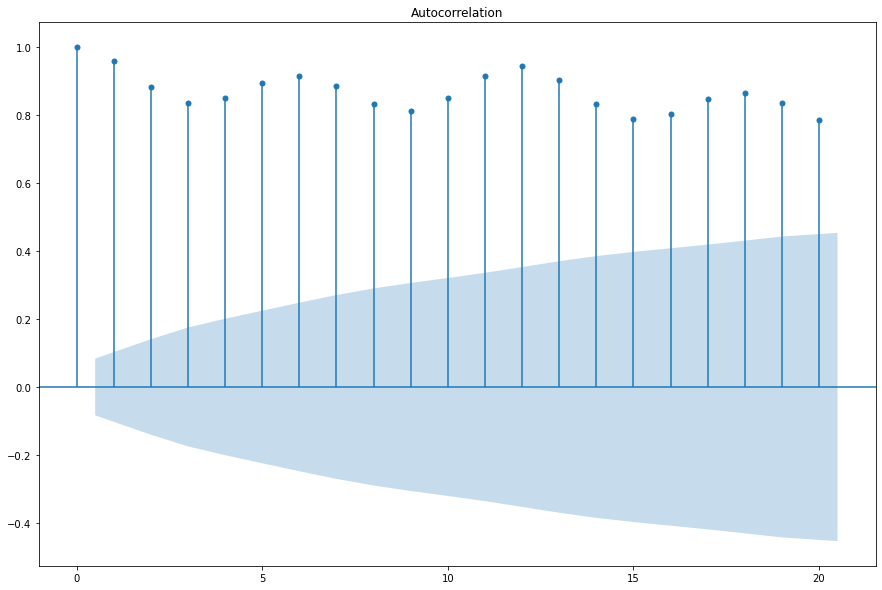

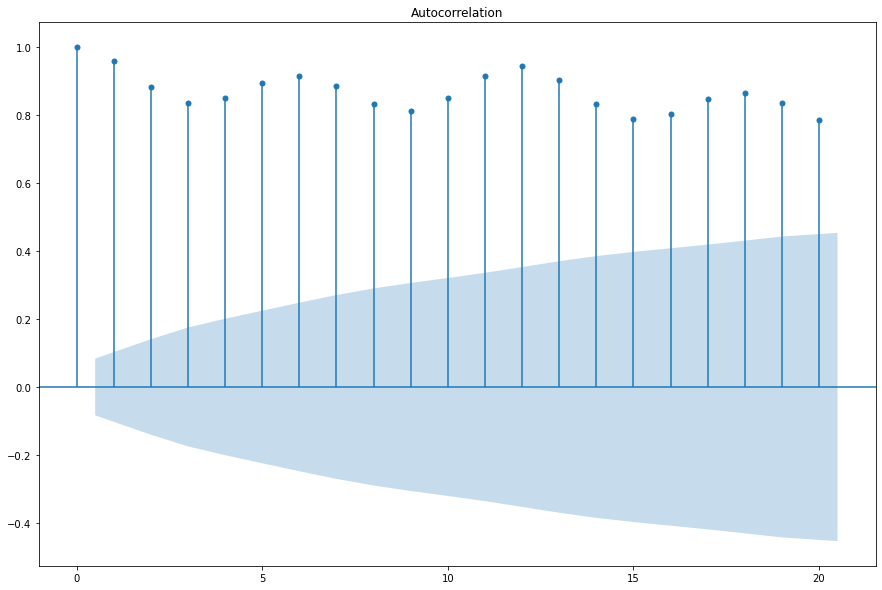

In [43]:
## Do some inisial checks to find which mehtod(ARIMA/SARIMA) is best suited for the data:

## (plotting od ACF) : 

smt.graphics.plot_acf(train.electricty_consumption_in_tw, lags=20)


## From this plot we can say that : 

## 1) There is an seasonality as there is a pattern. 
## 2) The data is not a staionary series data. (So we need to make it a staionary series data, its Pre-requsite) 



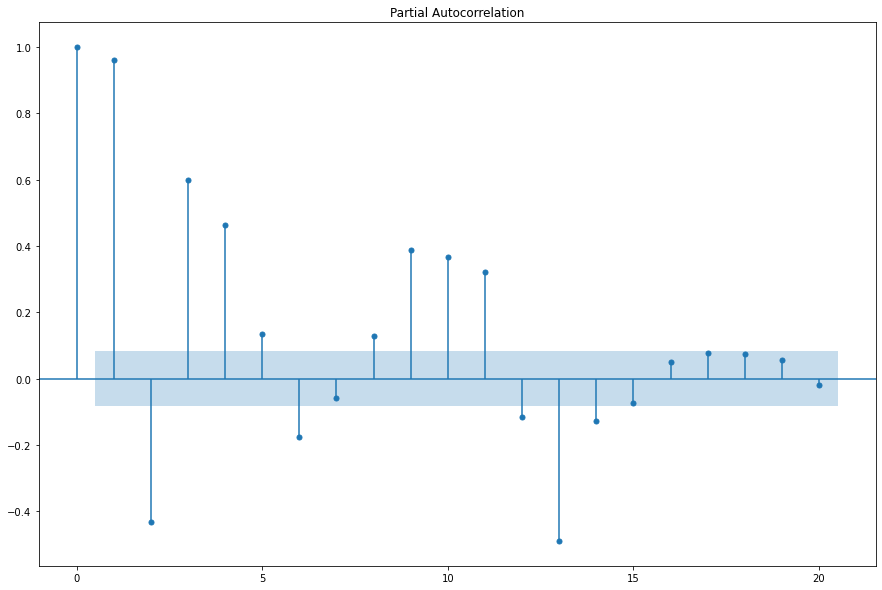

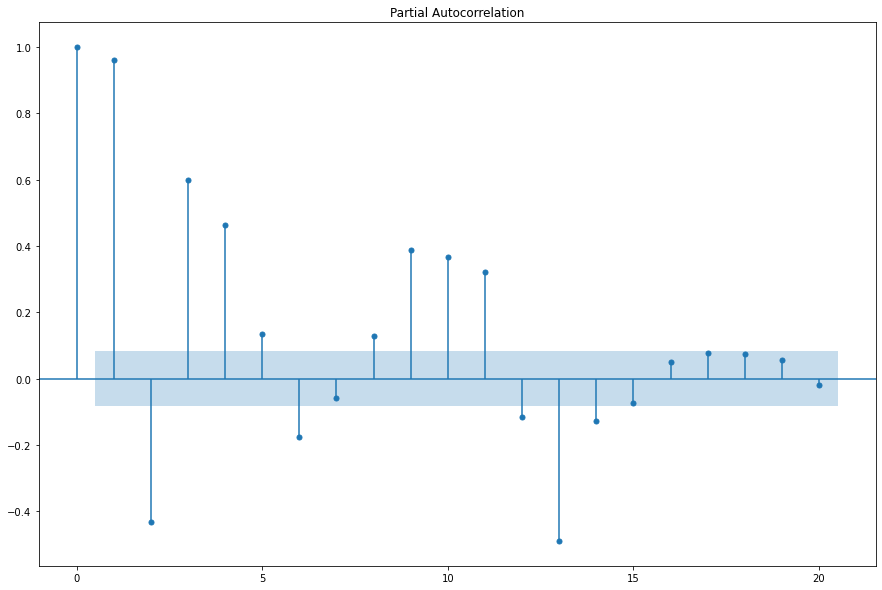

In [44]:
## (plotting od PACF) : 

smt.graphics.plot_pacf(train.electricty_consumption_in_tw, lags=20)

## Converting the non-stationary series data into statonary series data by transformation : 

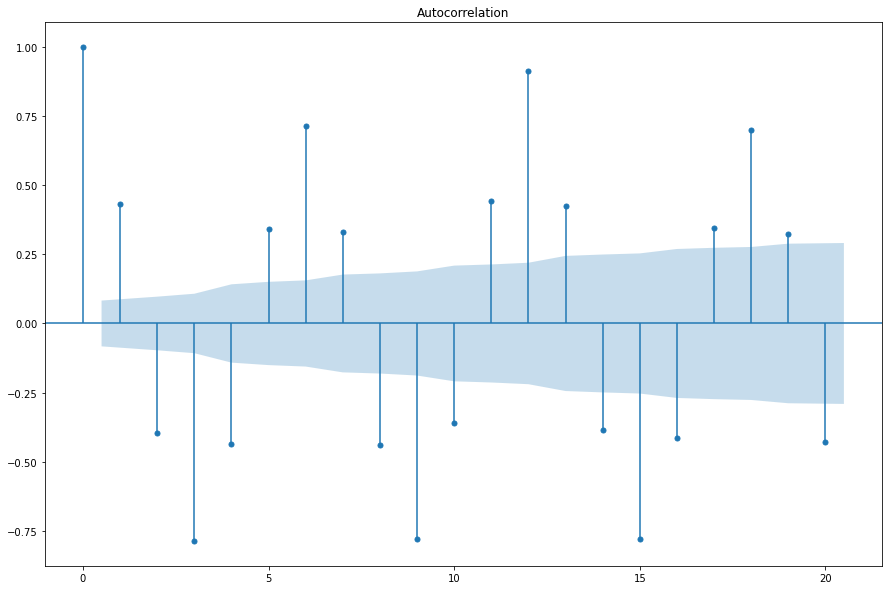

In [45]:
smt.graphics.plot_acf((np.log(data.electricty_consumption_in_tw).diff().dropna()), lags=20)

## Its showing stationary series 

## new data: 

new_train = data.electricty_consumption_in_tw.diff()

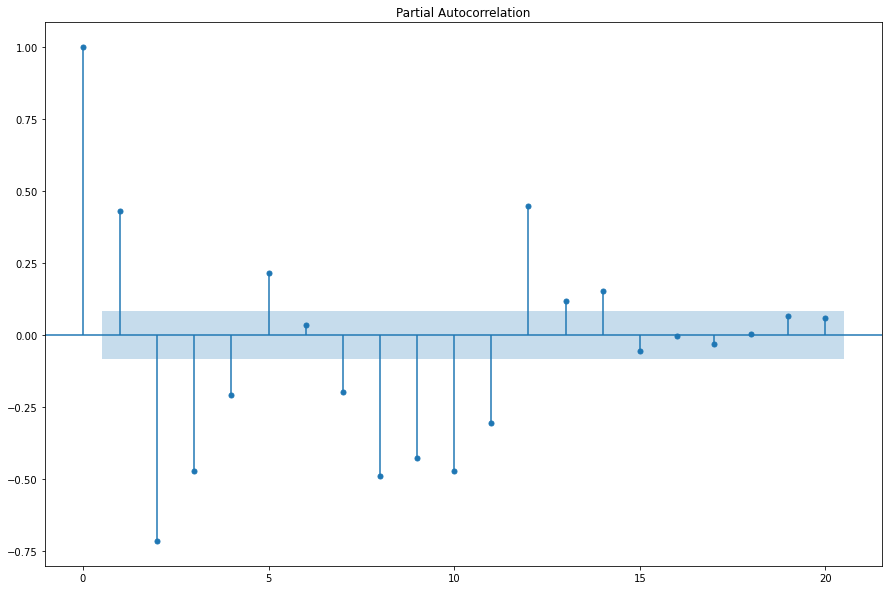

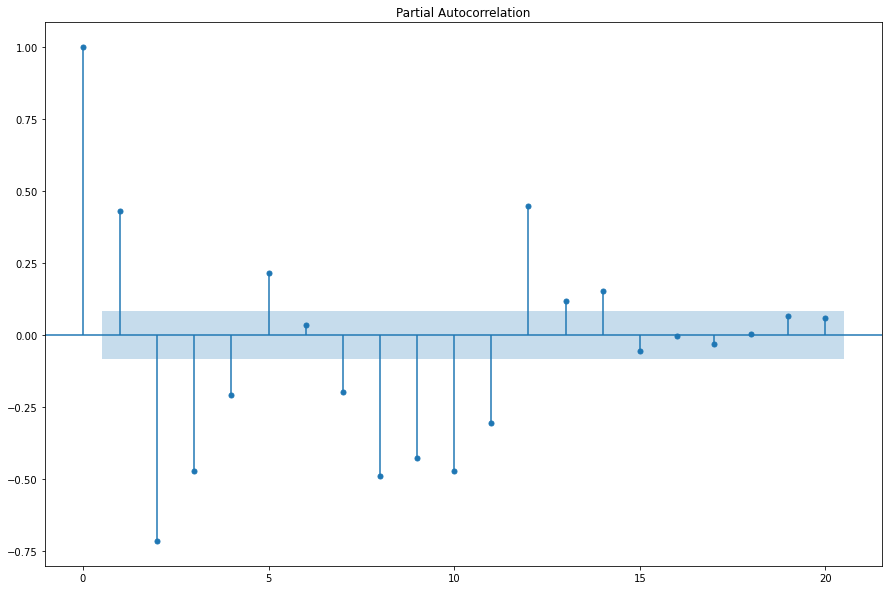

In [46]:
smt.graphics.plot_pacf((np.log(data.electricty_consumption_in_tw).diff().dropna()), lags=20)

## As we can see that from ACF plot the data have seasonality, so we are going to use SARIMA model : unknows are (p,d,q)(P,D,Q,T)

In [47]:
## calculating the unknows : 

p = 1
q = 1
d = 1   ## diff transformations 

P = 1 
Q = 1 
D = 0 
T = 12 

In [ ]:
import sys
import itertools
import warnings

def auto_arima(timeseries, regressors=None, p=range(0, 3), d=range(0, 2), q=range(0, 3),
              P=range(0, 3), D=range(0, 1), Q=range(0, 3)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, temp_results.aic))
                
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
                
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])
    #return best_results



best_results = auto_arima(new_train,  p=range(0, 3), d=range(0, 2), q=range(0, 3),
                         P=range(0, 3), D=range(0, 1), Q=range(0, 3))    


In [48]:
new_train = np.logtrain)

new_test = np.log(test)

In [70]:
sarima_model = sm.tsa.statespace.SARIMAX(new_train, order=(2,1,1), seasonal_order=(1,0,1,12)).fit()

In [64]:
sarima_forcast = np.exp(sarima_model.forecast(9))

In [65]:
## Validation of SARIMA Model  : 

## 1) RMSE : 

sarima_forcast = sarima_forcast.reset_index().set_index("index")
sarima_forcast.rename({0:"electricty_consumption_in_tw"},axis=1, inplace=True)

print('RMSE : ', np.sqrt(np.square(test-sarima_forcast).mean()))



RMSE :  electricty_consumption_in_tw    3.505973
dtype: float64


In [66]:
## 2) RMSPE :
print('RMSPE : ', np.sqrt(np.square((test-sarima_forcast)/test).mean()))

RMSPE :  electricty_consumption_in_tw    0.03155
dtype: float64


In [67]:
## 3) MAPE :  
print('MAPE : ',  ((test-sarima_forcast)/test).mean() )

MAPE :  electricty_consumption_in_tw    0.023774
dtype: float64


In [68]:
## Predection for next 2 years : 

np.exp(sarima_model.forecast(24))

2019-01-01    106.504242
2019-02-01     98.731407
2019-03-01     94.380179
2019-04-01     88.318716
2019-05-01     93.704283
2019-06-01    107.609441
2019-07-01    118.319597
2019-08-01    117.317474
2019-09-01    105.337009
2019-10-01     93.783121
2019-11-01     91.657955
2019-12-01    101.189747
2020-01-01    106.072864
2020-02-01     98.693518
2020-03-01     94.510640
2020-04-01     88.507309
2020-05-01     93.890489
2020-06-01    107.763943
2020-07-01    118.443447
2020-08-01    117.442004
2020-09-01    105.490667
2020-10-01     93.960607
2020-11-01     91.839308
2020-12-01    101.352522
Freq: MS, dtype: float64

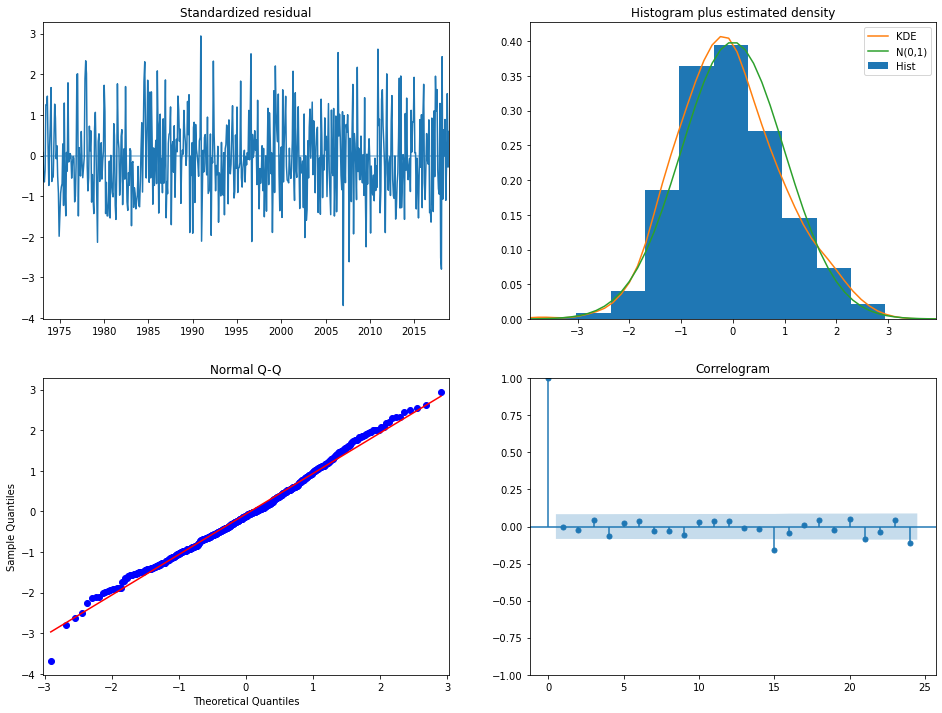

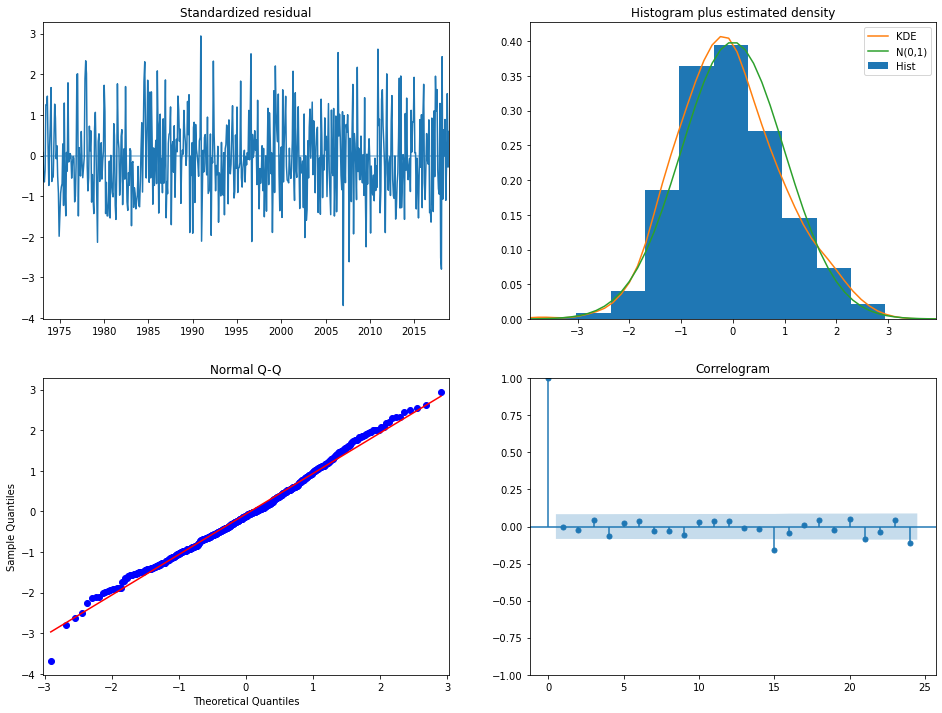

In [69]:
## Model Diagonstic : 

sarima_model.plot_diagnostics(lags=24,figsize=[16,12])

## AS we can see in correlogram plot there are some points beyond confidence index. 

In [ ]:
## I personally choose ETS model aS we can see in accuracy metric they as predicting  less error compare to SARIMA model and 
## also SARIMA model have some ACF values beyond confidence index.